In [1]:
    """
    Make a fits image cube where each frame has two images of the same galaxy drawn
    with regular FFT convolution and with photon shooting.

    We do this for 5 different PSFs and 5 different galaxies, each with 4 different (random)
    fluxes, sizes, and shapes.
    """
# Copyright (c) 2012-2021 by the GalSim developers team on GitHub
# https://github.com/GalSim-developers
#
# This file is part of GalSim: The modular galaxy image simulation toolkit.
# https://github.com/GalSim-developers/GalSim
#
# GalSim is free software: redistribution and use in source and binary forms,
# with or without modification, are permitted provided that the following
# conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions, and the disclaimer given in the accompanying LICENSE
#    file.
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions, and the disclaimer given in the documentation
#    and/or other materials provided with the distribution.
#
"""
Demo #7

The seventh script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)

This script introduces drawing profiles with photon shooting rather than doing the
convolution with an FFT.  It makes images using 5 different kinds of PSF and 5 different
kinds of galaxy.  Some of the parameters (flux, size and shape) are random variables, so
each of the 25 pairings is drawn 4 times with different realizations of the random numbers.
The profiles are drawn twice: once with the FFT method, and once with photon shooting.
The two images are drawn side by side into the same larger image so it is easy to
visually compare the results. The 100 total profiles are written to a FITS data cube,
which makes it easy to scroll through the images comparing the two drawing methods.


New features introduced in this demo:

- obj = galsim.Airy(lam_over_diam)
- obj = galsim.Sersic(n, half_light_radius, trunc)
- psf = galsim.OpticalPSF(..., aberrations=aberrations, ...)
- obj = obj.dilate(scale)
- str(obj)
- image.scale = pixel_scale
- obj.drawImage(image, method='fft')
- obj.drawImage(image, method='phot', max_extra_noise, rng)
- dev = galsim.PoissonDeviate(rng, mean)
- noise = galsim.DeviateNoise(dev)
- writeCube(..., compress='gzip')
- gsparams = galsim.GSParams(...)
"""

import sys
import os
import math
import numpy
import logging
import time
import galsim


def main(argv):

    logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
    logger = logging.getLogger("demo7")

    # To turn off logging:
    #logger.propagate = False

    # To turn on the debugging messages:
    #logger.setLevel(logging.DEBUG)

    # Define some parameters we'll use below.

    # Make output directory if not already present.
    if not os.path.isdir('output'):
        os.mkdir('output')

    file_name = os.path.join('output','cube_phot.fits.gz')

    random_seed = 553728
    sky_level = 1.e4        # ADU / arcsec^2
    pixel_scale = 0.28      # arcsec
    nx = 64
    ny = 64

    gal_flux_min = 1.e4     # Range for galaxy flux
    gal_flux_max = 1.e5
    gal_hlr_min = 0.3       # arcsec
    gal_hlr_max = 1.3       # arcsec
    gal_e_min = 0.          # Range for ellipticity
    gal_e_max = 0.8

    psf_fwhm = 0.65         # arcsec

    # This script is set up as a comparison between using FFTs for doing the convolutions and
    # shooting photons.  The two methods have trade-offs in speed and accuracy which vary
    # with the kind of profile being drawn and the S/N of the object, among other factors.
    # In addition, for each method, there are a number of parameters GalSim uses that control
    # aspects of the calculation that further affect the speed and accuracy.
    #
    # We encapsulate these parameters with an object called GSParams.  The default values
    # are intended to be accurate enough for normal precision shear tests, without sacrificing
    # too much speed.
    #
    # Any PSF or galaxy object can be given a gsparams argument on construction that can
    # have different values to make the calculation more or less accurate (typically trading
    # off for speed or memory).
    #
    # In this script, we adjust some of the values slightly, just to show you how it works.
    # You could play around with these values and see what effect they have on the drawn images.
    # Usually, it requires a pretty drastic change in these parameters for you to be able to
    # notice the difference by eye.  But subtle effects that may impact the shapes of galaxies
    # can happen well before then.

    # Type help(galsim.GSParams) for the complete list of parameters and more detailed
    # documentation, including the default values for each parameter.
    gsparams = galsim.GSParams(
        folding_threshold=1.e-2, # maximum fractional flux that may be folded around edge of FFT
        maxk_threshold=2.e-3,    # k-values less than this may be excluded off edge of FFT
        xvalue_accuracy=1.e-4,   # approximations in real space aim to be this accurate
        kvalue_accuracy=1.e-4,   # approximations in fourier space aim to be this accurate
        shoot_accuracy=1.e-4,    # approximations in photon shooting aim to be this accurate
        minimum_fft_size=64)     # minimum size of ffts

    logger.info('Starting demo script 7')

    # Make the PSF profiles:
    psf1 = galsim.Gaussian(fwhm = psf_fwhm, gsparams=gsparams)
    psf2 = galsim.Moffat(fwhm = psf_fwhm, beta = 2.4, gsparams=gsparams)
    psf3_inner = galsim.Gaussian(fwhm = psf_fwhm, flux = 0.8, gsparams=gsparams)
    psf3_outer = galsim.Gaussian(fwhm = 2*psf_fwhm, flux = 0.2, gsparams=gsparams)
    psf3 = psf3_inner + psf3_outer
    atmos = galsim.Gaussian(fwhm = psf_fwhm, gsparams=gsparams)
    # The OpticalPSF and set of Zernike values chosen below correspond to a reasonably well aligned,
    # smallish ~0.3m / 12 inch diameter telescope with a central obscuration of ~0.12m or 5 inches
    # diameter, being used in optical wavebands.
    # In the Noll convention, the value of the Zernike coefficient also gives the RMS optical path
    # difference across a circular pupil.  An RMS difference of ~0.5 or larger indicates that parts
    # of the wavefront are in fully destructive interference, and so we might expect aberrations to
    # become strong when Zernike aberrations summed in quadrature approach 0.5 wave.
    # The aberrations chosen in this case correspond to operating close to a 0.25 wave RMS optical
    # path difference.  Unlike in demo3, we specify the aberrations by making a list that we pass
    # in using the 'aberrations' kwarg.  The order of aberrations starting from index 4 is defocus,
    # astig1, astig2, coma1, coma2, trefoil1, trefoil2, spher as in the Noll convention.
    # We ignore the first 4 values so that the index number corresponds to the Zernike index
    # in the Noll convention. This will be particularly convenient once we start allowing
    # coefficients beyond spherical (index 11).  c.f. The Wikipedia page about the Noll indices:
    #
    #     http://en.wikipedia.org/wiki/Zernike_polynomials#Zernike_polynomials

    aberrations = [ 0.0 ] * 12          # Set the initial size.
    aberrations[4] = 0.06               # Noll index 4 = Defocus
    aberrations[5:7] = [ 0.12, -0.08 ]  # Noll index 5,6 = Astigmatism
    aberrations[7:9] = [ 0.07, 0.04 ]   # Noll index 7,8 = Coma
    aberrations[11] = -0.13             # Noll index 11 = Spherical
    # You could also define these all at once if that is more convenient:
    #aberrations = [0.0, 0.0, 0.0, 0.0, 0.06, 0.12, -0.08, 0.07, 0.04, 0.0, 0.0, -0.13]

    optics = galsim.OpticalPSF(
        lam_over_diam = 0.6 * psf_fwhm, obscuration = 0.4, aberrations = aberrations,
        gsparams=gsparams)
    psf4 = galsim.Convolve([atmos, optics]) # Convolve inherits the gsparams from the first
                                            # item in the list.  (Or you can supply a gsparams
                                            # argument explicitly if you want to override this.)
    atmos = galsim.Kolmogorov(fwhm = psf_fwhm, gsparams=gsparams)
    optics = galsim.Airy(lam_over_diam = 0.3 * psf_fwhm, gsparams=gsparams)
    psf5 = galsim.Convolve([atmos,optics])
    psfs = [psf1, psf2, psf3, psf4, psf5]
    psf_names = ["Gaussian", "Moffat", "Double Gaussian", "OpticalPSF", "Kolmogorov * Airy"]
    psf_times = [0,0,0,0,0]
    psf_fft_times = [0,0,0,0,0]
    psf_phot_times = [0,0,0,0,0]

    # Make the galaxy profiles:
    gal1 = galsim.Gaussian(half_light_radius = 1, gsparams=gsparams)
    gal2 = galsim.Exponential(half_light_radius = 1, gsparams=gsparams)
    gal3 = galsim.DeVaucouleurs(half_light_radius = 1, gsparams=gsparams)
    gal4 = galsim.Sersic(half_light_radius = 1, n = 2.5, gsparams=gsparams)
    # A Sersic profile may be truncated if desired.
    # The units for this are expected to be arcsec (or specifically -- whatever units
    # you are using for all the size values as defined by the pixel_scale).
    bulge = galsim.Sersic(flux=0.4, half_light_radius=0.7, n=3.2, trunc=8.5, gsparams=gsparams)
    disk = galsim.Sersic(flux=0.6, half_light_radius=1.2, n=1.5, gsparams=gsparams)
    gal5 = bulge + disk  # Net half-light radius is only approximate for this one.
    gals = [gal1, gal2, gal3, gal4, gal5]
    gal_names = ["Gaussian", "Exponential", "Devaucouleurs", "n=2.5 Sersic", "Bulge + Disk"]
    gal_times = [0,0,0,0,0]
    gal_fft_times = [0,0,0,0,0]
    gal_phot_times = [0,0,0,0,0]

    # Other times to keep track of:
    setup_times = 0
    fft_times = 0
    phot_times = 0
    noise_times = 0

    # Loop over combinations of psf, gal, and make 4 random choices for flux, size, shape.
    all_images = []
    k = 0
    for ipsf in range(len(psfs)):
        psf = psfs[ipsf]
        psf_name = psf_names[ipsf]
        logger.info('psf %d: %s',ipsf+1,psf)
        # Note that this implicitly calls str(psf).  We've made an effort to give all GalSim
        # objects an informative but relatively succinct str representation.  Some details may
        # be missing, but it should look essentially like how you would create the object.
        logger.debug('repr = %r',psf)
        # The repr() version are a bit more pedantic in form and should be completely informative,
        # to the point where two objects that are not identical should never have equal repr
        # strings. As such the repr strings may in some cases be somewhat unwieldy.  For instance,
        # since we set non-default gsparams in these, the repr includes that information, but
        # it is omitted from the str for brevity.
        for igal in range(len(gals)):
            gal = gals[igal]
            gal_name = gal_names[igal]
            logger.info('   galaxy %d: %s',igal+1,gal)
            logger.debug('   repr = %r',gal)
            for i in range(4):
                logger.debug('      Start work on image %d',i)
                t1 = time.time()

                # Initialize the random number generator we will be using.
                rng = galsim.UniformDeviate(random_seed+k+1)

                # Generate random variates:
                flux = rng() * (gal_flux_max-gal_flux_min) + gal_flux_min

                # Use a new variable name, since we'll want to keep the original unmodified.
                this_gal = gal.withFlux(flux)

                hlr = rng() * (gal_hlr_max-gal_hlr_min) + gal_hlr_min
                this_gal = this_gal.dilate(hlr)

                beta_ellip = rng() * 2*math.pi * galsim.radians
                ellip = rng() * (gal_e_max-gal_e_min) + gal_e_min
                gal_shape = galsim.Shear(e=ellip, beta=beta_ellip)
                this_gal = this_gal.shear(gal_shape)

                # Build the final object by convolving the galaxy and PSF.
                final = galsim.Convolve([this_gal, psf])

                # Create the large, double width output image
                # Rather than provide a scale= argument to the drawImage commands, we can also
                # set the pixel scale in the image constructor.
                # Note: You can also change it after the construction with im.scale=pixel_scale
                image = galsim.ImageF(2*nx+2, ny, scale=pixel_scale)

                # Assign the following two Image "views", fft_image and phot_image.
                # Using the syntax below, these are views into the larger image.
                # Changes/additions to the sub-images referenced by the views are automatically
                # reflected in the original image.
                fft_image = image[galsim.BoundsI(1, nx, 1, ny)]
                phot_image = image[galsim.BoundsI(nx+3, 2*nx+2, 1, ny)]

                logger.debug('      Read in training sample galaxy and PSF from file')
                t2 = time.time()

                # Draw the profile
                # This default rendering method (method='auto') usually defaults to FFT, since
                # that is normally the most efficient method.  However, we can also set method
                # to 'fft' explicitly to force it to always use FFTs for the convolution
                # by the pixel response.  (In this case, it doesn't have any effect, since
                # the 'auto' method would have always chosen 'fft' anyway, so this is just
                # for illustrative purposes.)
                final.drawImage(fft_image, method='fft')

                logger.debug('      Drew fft image.  Total drawn flux = %f.  .flux = %f',
                             fft_image.array.sum(),final.flux)
                t3 = time.time()

                # Add Poisson noise
                sky_level_pixel = sky_level * pixel_scale**2
                fft_image.addNoise(galsim.PoissonNoise(rng, sky_level=sky_level_pixel))

                t4 = time.time()

                # The next two lines are just to get the output from this demo script
                # to match the output from the parsing of demo7.yaml.
                rng = galsim.UniformDeviate(random_seed+k+1)
                rng(); rng(); rng(); rng();

                # Repeat for photon shooting image.
                # The max_extra_noise parameter indicates how much extra noise per pixel we are
                # willing to tolerate.  The sky noise will be adding a variance of sky_level_pixel,
                # so we allow up to 1% of that extra.
                final.drawImage(phot_image, method='phot', max_extra_noise=sky_level_pixel/100,
                                rng=rng)
                t5 = time.time()

                # For photon shooting, galaxy already has Poisson noise, so we want to make
                # sure not to add that noise again!  Thus, we just add sky noise, which
                # is Poisson with the mean = sky_level_pixel
                pd = galsim.PoissonDeviate(rng, mean=sky_level_pixel)
                # DeviateNoise just adds the action of the given deviate to every pixel.
                phot_image.addNoise(galsim.DeviateNoise(pd))
                # For PoissonDeviate, the mean is not zero, so for a background-subtracted
                # image, we need to subtract the mean back off when we are done.
                phot_image -= sky_level_pixel

                logger.debug('      Added Poisson noise.  Image fluxes are now %f and %f',
                             fft_image.array.sum(), phot_image.array.sum())
                t6 = time.time()

                # Store that into the list of all images
                all_images += [image]

                k = k+1
                logger.info('      %d: flux = %.2e, hlr = %.2f, ellip = (%.2f,%.2f)',
                            k, flux, hlr, gal_shape.e1, gal_shape.e2)
                logger.debug('      Times: %f, %f, %f, %f, %f',t2-t1, t3-t2, t4-t3, t5-t4, t6-t5)

                psf_times[ipsf] += t6-t1
                psf_fft_times[ipsf] += t3-t2
                psf_phot_times[ipsf] += t5-t4
                gal_times[igal] += t6-t1
                gal_fft_times[igal] += t3-t2
                gal_phot_times[igal] += t5-t4
                setup_times += t2-t1
                fft_times += t3-t2
                phot_times += t5-t4
                noise_times += t4-t3 + t6-t5

    logger.info('Done making images of galaxies')
    logger.info('')
    logger.info('Some timing statistics:')
    logger.info('   Total time for setup steps = %f',setup_times)
    logger.info('   Total time for regular fft drawing = %f',fft_times)
    logger.info('   Total time for photon shooting = %f',phot_times)
    logger.info('   Total time for adding noise = %f',noise_times)
    logger.info('')
    logger.info('Breakdown by PSF type:')
    for ipsf in range(len(psfs)):
        logger.info('   %s: Total time = %f  (fft: %f, phot: %f)',
                    psf_names[ipsf],psf_times[ipsf],psf_fft_times[ipsf],psf_phot_times[ipsf])
    logger.info('')
    logger.info('Breakdown by Galaxy type:')
    for igal in range(len(gals)):
        logger.info('   %s: Total time = %f  (fft: %f, phot: %f)',
                    gal_names[igal],gal_times[igal],gal_fft_times[igal],gal_phot_times[igal])
    logger.info('')

    # Now write the image to disk.
    # With any write command, you can optionally compress the file using several compression
    # schemes:
    #   'gzip' uses gzip on the full output file.
    #   'bzip2' uses bzip2 on the full output file.
    #   'rice' uses rice compression on the image, leaving the fits headers readable.
    #   'gzip_tile' uses gzip in tiles on the output image, leaving the fits headers readable.
    #   'hcompress' uses hcompress on the image, but it is only valid for 2-d data, so it
    #               doesn't work for writeCube.
    #   'plio' uses plio on the image, but it is only valid for positive integer data.
    # Furthermore, the first three have standard filename extensions associated with them,
    # so if you don't specify a compression, but the filename ends with '.gz', '.bz2' or '.fz',
    # the corresponding compression will be selected automatically.
    # In other words, the `compression='gzip'` specification is actually optional here:
    galsim.fits.writeCube(all_images, file_name, compression='gzip')
    logger.info('Wrote fft image to fits data cube %r',file_name)


if __name__ == "__main__":
    main(sys.argv)

Starting demo script 7
psf 1: galsim.Gaussian(sigma=0.2760295850936062)
   galaxy 1: galsim.Gaussian(sigma=0.8493218002880191)
      1: flux = 7.86e+04, hlr = 0.59, ellip = (-0.69,0.40)
      2: flux = 2.36e+04, hlr = 0.75, ellip = (0.20,0.16)
      3: flux = 9.02e+04, hlr = 0.47, ellip = (-0.70,0.39)
      4: flux = 9.01e+04, hlr = 0.36, ellip = (-0.26,-0.18)
   galaxy 2: galsim.Exponential(scale_radius=0.5958243473776976)
      5: flux = 7.84e+04, hlr = 0.50, ellip = (-0.17,0.19)
      6: flux = 6.18e+04, hlr = 1.09, ellip = (0.02,-0.01)
      7: flux = 5.26e+04, hlr = 0.32, ellip = (0.24,-0.02)
      8: flux = 8.67e+04, hlr = 0.59, ellip = (0.00,0.07)
   galaxy 3: galsim.DeVaucouleurs(half_light_radius=1.0)
      9: flux = 9.96e+04, hlr = 1.05, ellip = (0.20,0.05)
      10: flux = 8.84e+04, hlr = 0.91, ellip = (0.06,0.23)
      11: flux = 3.34e+04, hlr = 1.05, ellip = (0.24,-0.45)
      12: flux = 7.95e+04, hlr = 0.83, ellip = (0.04,-0.09)
   galaxy 4: galsim.Sersic(n=2.5, half_ligh

      98: flux = 6.12e+04, hlr = 0.95, ellip = (0.41,0.23)
      99: flux = 1.53e+04, hlr = 0.98, ellip = (-0.17,0.31)
      100: flux = 8.07e+04, hlr = 0.94, ellip = (-0.39,-0.14)
Done making images of galaxies

Some timing statistics:
   Total time for setup steps = 0.046095
   Total time for regular fft drawing = 0.459587
   Total time for photon shooting = 2.358788
   Total time for adding noise = 0.092991

Breakdown by PSF type:
   Gaussian: Total time = 0.459595  (fft: 0.154223, phot: 0.276361)
   Moffat: Total time = 0.349682  (fft: 0.091136, phot: 0.228213)
   Double Gaussian: Total time = 0.328122  (fft: 0.036868, phot: 0.263691)
   OpticalPSF: Total time = 1.325919  (fft: 0.115017, phot: 1.184855)
   Kolmogorov * Airy: Total time = 0.494143  (fft: 0.062343, phot: 0.405668)

Breakdown by Galaxy type:
   Gaussian: Total time = 0.771589  (fft: 0.086344, phot: 0.656426)
   Exponential: Total time = 0.523221  (fft: 0.040545, phot: 0.454226)
   Devaucouleurs: Total time = 0.663887 

In [10]:
from astropy.utils.data import download_file
from astropy.io import fits
import matplotlib.pyplot as plt
image_file = "output//cube_phot.fits.gz"
hdu = fits.open(image_file)[0]
image_data = hdu.data
image_data.shape

(100, 64, 130)

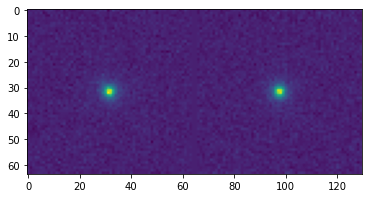

In [36]:
plt.imshow(image_data[50])

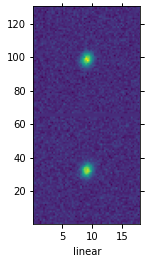

In [37]:
from astropy.wcs import WCS
wcs = WCS(hdu.header)
ax = plt.subplot(projection=wcs, slices=(1, 'x', 'y'))
ax.imshow(image_data[1, :, :].transpose())